In [1]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression as lr
from sklearn.preprocessing import StandardScaler
import statistics

In [64]:
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings
# or specifically for yfinance
import warnings
warnings.filterwarnings("ignore", message="YF.download() has changed argument auto_adjust")

In [37]:
# Initialize global variables if needed
comparison = pd.DataFrame()
indicative_investing = []
continuous_investing = []

In [5]:
# Get user inputs
ticker_input = input("Please enter the stock tickers you would like to invest in.\n")
start_date = input("Here enter the date from which data will begin to be taken from (Please put it into the format of YYYY-MM-DD)\n")
test_date = input("Here enter the date from which training and testing will end (Please put it into the format of YYYY-MM-DD)\n")
end_date = input("Here enter the date at which we will stop taking data from (Please put it into the format of YYYY-MM-DD)\n")


Please enter the stock tickers you would like to invest in.
 AMD
Here enter the date from which data will begin to be taken from (Please put it into the format of YYYY-MM-DD)
 2025-01-01
Here enter the date from which training and testing will end (Please put it into the format of YYYY-MM-DD)
 2025-11-30
Here enter the date at which we will stop taking data from (Please put it into the format of YYYY-MM-DD)
 2025-12-31


In [68]:
# Download data using yfinance
# Fix 1: Add auto_adjust=False to suppress the warning
test_data = yf.download(ticker_input, start=start_date, end=test_date, auto_adjust=False, progress=False)
data = yf.download(ticker_input, start=test_date, end=end_date, auto_adjust=False, progress=False)

# Now use the validated dates
print(f"Using dates: start={start_date}, test={test_date}, end={end_date}")

Using dates: start=2025-01-01, test=2025-12-01 00:00:00, end=2025-12-31


In [39]:
# Handle MultiIndex columns from yfinance
def flatten_columns(df):
    """Flatten MultiIndex columns to single level"""
    if isinstance(df.columns, pd.MultiIndex):
        # If single ticker, keep column names as is
        if len(df.columns.levels[1]) == 1:
            df.columns = df.columns.droplevel(1)
        else:
            # For multiple tickers, join the column names
            df.columns = [' '.join(col).strip() for col in df.columns.values]
    return df

In [40]:
test_data = flatten_columns(test_data)
data = flatten_columns(data)

print(f"Test data shape: {test_data.shape}")
print(f"Main data shape: {data.shape}")

Test data shape: (228, 5)
Main data shape: (21, 5)


In [41]:
# Check if we have 'Adj Close' or 'Close' column
if 'Adj Close' in test_data.columns:
    price_col = 'Adj Close'
elif 'Close' in test_data.columns:
    price_col = 'Close'
    test_data = test_data.rename(columns={'Close': 'Adj Close'})
    data = data.rename(columns={'Close': 'Adj Close'})
else:
    raise ValueError("No price column found in the data")

print(f"Using '{price_col}' as price column")

print(f"Test data shape: {test_data.shape}")
print(f"Main data shape: {data.shape}")

Using 'Close' as price column
Test data shape: (228, 5)
Main data shape: (21, 5)


In [48]:
# Prepare the model
# This Forecast Out will predict 1 day into the future
f_out = int(1)
test_data['Predicting'] = test_data['Adj Close'].shift(-f_out)
# Create a copy of test_data for feature engineering
test_data_processed = test_data.copy()

# Ensure we have enough data
if len(test_data_processed) <= f_out:
    raise ValueError(f"Not enough test data. Need at least {f_out + 1} days, got {len(test_data_processed)}")

# Create target variable (shifted price)
test_data_processed['Predicting'] = test_data_processed['Adj Close'].shift(-f_out)

# Drop rows with NaN in target
test_data_processed = test_data_processed.dropna(subset=['Predicting'])

# Prepare features and target
feature_columns = [col for col in test_data_processed.columns if col != 'Predicting']
X = np.array(test_data_processed[feature_columns])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Separate prediction data
X_prediction = X_scaled[-f_out:]
X_scaled = X_scaled[:-f_out]

Y = np.array(test_data_processed['Predicting'])
Y = Y[:-f_out]

print(f"X shape: {X_scaled.shape}, Y shape: {Y.shape}")

X shape: (226, 5), Y shape: (226,)


In [50]:
# Split data into train and test sets
X_train, X_test, Y_train, Y_test = tts(X_scaled, Y, test_size=0.2, random_state=42)


In [51]:
# Create and train the model
model = lr()
model.fit(X_train, Y_train)

,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [52]:
# Print confidence of initial model
conf = model.score(X_test, Y_test)
print(f"Model Confidence (R² score): {conf:.4f}")

Model Confidence (R² score): 0.9805


In [53]:
# Make prediction
prediction = model.predict(X_prediction)
r = 0
print(f"Predicted value: {prediction[0]:.2f}")

Predicted value: 212.74


In [54]:
indices = data.index.tolist()
test_date = indices[r]
print(prediction - test_data.iloc[len(test_data)-1]['Adj Close'])

[-4.78861583]


In [55]:
def investing_model(r):
    """
    Function to make investment decisions based on predictions
    """
    try:
        # Get the date for this iteration
        current_test_date = data.index[r]
        
        # Get data up to current_test_date for training
        temp_data = yf.download(ticker_input, start=start_date, end=current_test_date, progress=False)
        temp_data = flatten_columns(temp_data)
        
        # Ensure we have the price column
        if 'Adj Close' not in temp_data.columns and 'Close' in temp_data.columns:
            temp_data = temp_data.rename(columns={'Close': 'Adj Close'})
        
        # CRITICAL FIX: Make sure temp_data has ALL the same columns as original training data
        # Add missing columns with NaN or 0 values
        for col in feature_columns:  # Use the global feature_columns from training
            if col not in temp_data.columns:
                temp_data[col] = 0  # or temp_data[col] = np.nan
        
        # Reorder columns to match original order
        temp_data = temp_data[feature_columns]
        
        # Prepare data for prediction
        if len(temp_data) > f_out + 5:  # Need enough data
            temp_data_processed = temp_data.copy()
            temp_data_processed['Predicting'] = temp_data_processed['Adj Close'].shift(-f_out)
            temp_data_processed = temp_data_processed.dropna(subset=['Predicting'])
            
            # Prepare features - use the same feature_columns
            X_temp = np.array(temp_data_processed[feature_columns])
            
            if len(X_temp) > 0:
                X_temp_scaled = scaler.transform(X_temp)  # Now will have correct number of features
                X_pred_temp = X_temp_scaled[-f_out:]
                
                # Train model on this data
                X_temp_train = X_temp_scaled[:-f_out]
                Y_temp = np.array(temp_data_processed['Predicting'])
                Y_temp = Y_temp[:-f_out]
                
                if len(X_temp_train) > 5 and len(Y_temp) > 5:
                    temp_model = lr()
                    temp_model.fit(X_temp_train, Y_temp)
                    pred = temp_model.predict(X_pred_temp)
                    
                    # Calculate return prediction
                    last_price = temp_data_processed.iloc[-1]['Adj Close']
                    predicted_return = pred[0] - last_price
                    return [predicted_return]
    
    except Exception as e:
        print(f"Error in investing_model at r={r}: {e}")
    
    return [0]  # Return 0 if not enough data or error

In [56]:
# Initialize tracking variables
last_true = 0
indicative_investing = []
continuous_investing = []

In [57]:
# Run investment simulation
for r in range(1, min(30, len(data))):  # Limit to first 30 days or data length
    x = investing_model(r)[0]  # x is a scalar value
    
    # Track indicative investing strategy
    if x > 0:  # NOT x.all() > 0 - x is not an array
        price_change = data.iloc[r]['Adj Close'] - data.iloc[r-1]['Adj Close']
        last_true = last_true + price_change
    
    indicative_investing.append(last_true)

/tmp/ipykernel_10245/4208760553.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  temp_data = yf.download(ticker_input, start=start_date, end=current_test_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_10245/4208760553.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  temp_data = yf.download(ticker_input, start=start_date, end=current_test_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_10245/4208760553.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  temp_data = yf.download(ticker_input, start=start_date, end=current_test_date)
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_10245/4208760553.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  temp_data = yf.download(ticker_input, start=start_date, end=current_test_date)
[

In [ ]:
# After your initial training code, define feature_columns globally
feature_columns = [col for col in test_data_processed.columns if col != 'Predicting']

# Then use this same feature_columns list in investing_model()
print(f"feature_columns {feature_columns}")

In [58]:
# Create comparison DataFrame
comparison = pd.DataFrame({
    f'{ticker_input} Indicative Investing': indicative_investing,
    f'{ticker_input} Continuous Investing': continuous_investing[:len(indicative_investing)]
})

print("\nInvestment Strategy Comparison:")
print(comparison.tail())


Investment Strategy Comparison:
    AMD Indicative Investing  AMD Continuous Investing
15                 -4.860001                 -4.860001
16                 -4.720001                 -4.720001
17                 -4.769989                 -4.769989
18                 -4.149994                 -4.149994
19                 -4.419998                 -4.419998


In [59]:
# Calculate outperformance percentage
def outperformance_percentage():
    outperformance_count = 0
    total_count = 0

    for r in range(0, len(comparison.index)):
        if comparison[f'{ticker_input} Indicative Investing'].iloc[r] > comparison[f'{ticker_input} Continuous Investing'].iloc[r]:
            outperformance_count += 1
        total_count += 1
    
    outperformance_percentage = (outperformance_count / total_count) * 100
    return outperformance_percentage

In [60]:
# Calculate standard deviation
def calculate_standard_deviation(data_list):
    if len(data_list) <= 1:
        return 0
    
    mean_value = statistics.mean(data_list)
    variance = sum((x - mean_value) ** 2 for x in data_list) / (len(data_list) - 1)
    return variance ** 0.5

In [61]:
# Display results
print(f"\n{'='*50}")
print("RESULTS SUMMARY")
print(f"{'='*50}")
print(f"Model Confidence (R²): {conf:.4f}")
print(f"Outperformance Percentage: {outperformance_percentage():.2f}%")
print(f"Standard Deviation of Indicative Strategy: {calculate_standard_deviation(indicative_investing):.4f}")
print(f"Standard Deviation of Continuous Strategy: {calculate_standard_deviation(continuous_investing[:len(indicative_investing)]):.4f}")


RESULTS SUMMARY
Model Confidence (R²): 0.9805
Outperformance Percentage: 0.00%
Standard Deviation of Indicative Strategy: 6.3072
Standard Deviation of Continuous Strategy: 6.4275


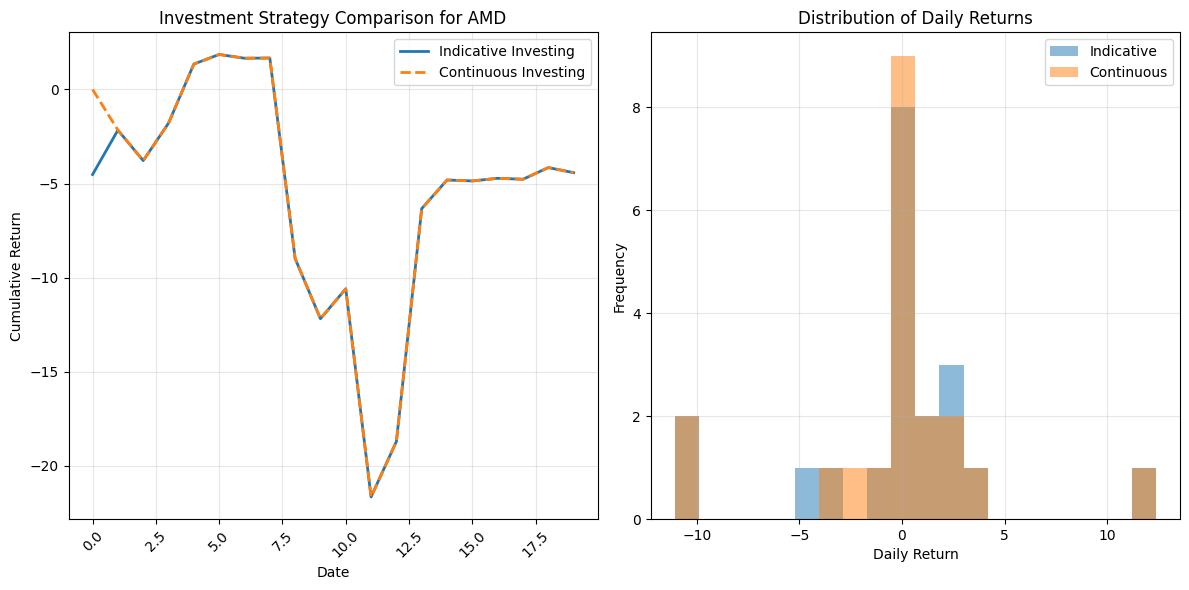

In [62]:
try:
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 6))
    
    # Plot cumulative returns
    plt.subplot(1, 2, 1)
    plt.plot(comparison.index, comparison[f'{ticker_input} Indicative Investing'], 
             label='Indicative Investing', linewidth=2)
    plt.plot(comparison.index, comparison[f'{ticker_input} Continuous Investing'], 
             label='Continuous Investing', linewidth=2, linestyle='--')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title(f'Investment Strategy Comparison for {ticker_input}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Plot histogram of daily returns
    plt.subplot(1, 2, 2)
    returns_indicative = np.diff([0] + indicative_investing)
    returns_continuous = np.diff([0] + continuous_investing[:len(indicative_investing)])
    
    plt.hist(returns_indicative, alpha=0.5, label='Indicative', bins=20)
    plt.hist(returns_continuous, alpha=0.5, label='Continuous', bins=20)
    plt.xlabel('Daily Return')
    plt.ylabel('Frequency')
    plt.title('Distribution of Daily Returns')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("\nNote: Install matplotlib with 'pip install matplotlib' to see the plot.")

In [63]:
# Additional statistics
print(f"\n{'='*50}")
print("ADDITIONAL STATISTICS")
print(f"{'='*50}")
print(f"Total Indicative Return: {indicative_investing[-1] if indicative_investing else 0:.2f}")
print(f"Total Continuous Return: {continuous_investing[-1] if continuous_investing else 0:.2f}")
print(f"Number of Trading Days Analyzed: {len(indicative_investing)}")
print(f"Average Daily Return (Indicative): {np.mean(np.diff([0] + indicative_investing)) if indicative_investing else 0:.4f}")
print(f"Average Daily Return (Continuous): {np.mean(np.diff([0] + continuous_investing[:len(indicative_investing)])) if continuous_investing else 0:.4f}")


ADDITIONAL STATISTICS
Total Indicative Return: -4.42
Total Continuous Return: -4.42
Number of Trading Days Analyzed: 20
Average Daily Return (Indicative): -0.2210
Average Daily Return (Continuous): -0.2210
